In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,r2_score,mean_absolute_error,mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost
import joblib
%matplotlib inline

In [5]:
df = pd.read_csv('preprocessed_total_0603.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90802 entries, 0 to 90801
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_url        90802 non-null  int64  
 1   car_area       90802 non-null  object 
 2   car_no         90802 non-null  object 
 3   car_brand      90802 non-null  object 
 4   nation         90802 non-null  object 
 5   car_name       90802 non-null  object 
 6   name_datailed  90802 non-null  object 
 7   new_price      90802 non-null  int64  
 8   price          90802 non-null  int64  
 9   year           90802 non-null  int64  
 10  use            90802 non-null  int64  
 11  depreciation   90802 non-null  int64  
 12  mileage        90802 non-null  int64  
 13  fuel           90802 non-null  object 
 14  forecast_min   90802 non-null  int64  
 15  forecast_max   90802 non-null  int64  
 16  car_type       90802 non-null  object 
 17  car_cc         90802 non-null  int64  
 18  color 

# 랜덤포레스트 + 그리드서치

In [33]:
X = df[['use','nation','car_brand','car_name','mileage','year','car_type','fuel','trans','loss','flood','usage','change','insurance']] 
Y = df[['depreciation']]

In [34]:
encoded_X = pd.get_dummies(data = X, columns = ['nation','car_brand','car_name','car_type','fuel','trans','loss','flood','usage','insurance'])

In [35]:
s_scale = StandardScaler()
s_scale.fit(encoded_X)
scaled_X= s_scale.transform(encoded_X)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X,Y, random_state = 5, test_size = 0.25)

In [11]:
params ={'n_estimators':[10,20,30,40,50,100]}

In [37]:
randforest = RandomForestRegressor() # 모델 정의

In [13]:
grid_cv = GridSearchCV(randforest, param_grid=params, cv=3, n_jobs=-1)
grid_cv.fit(X_train,y_train)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 100]})

In [14]:
print(f"Best Param: {grid_cv.best_params_}")
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))
n_estimators = grid_cv.best_params_['n_estimators']

Best Param: {'n_estimators': 100}
최고 예측 정확도: 0.9141


In [38]:
randforest = RandomForestRegressor(n_estimators=200) # 모델 정의

In [39]:
randforest.fit(X_train, np.ravel(y_train))

RandomForestRegressor(n_estimators=200)

In [40]:
# 모델명 변경해주기

randomforest_predict = randforest.predict(X_test)

In [41]:
# 모델명, acc.append 부분 model 이름 변경해주기

print(f'train acc : {randforest.score(X_train, y_train)}')
print(f'test acc : {randforest.score(X_test, y_test)}')
print(f'MAE : {mean_absolute_error(y_test, randomforest_predict)}')
print(f'MSE : {mean_squared_error(y_test, randomforest_predict)}')
print(f'r2_score : {r2_score(y_test,randomforest_predict)}')

train acc : 0.9886182298882991
test acc : 0.914631931158265
MAE : 4.816375901208464
MSE : 47.416608823818414
r2_score : 0.914631931158265


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


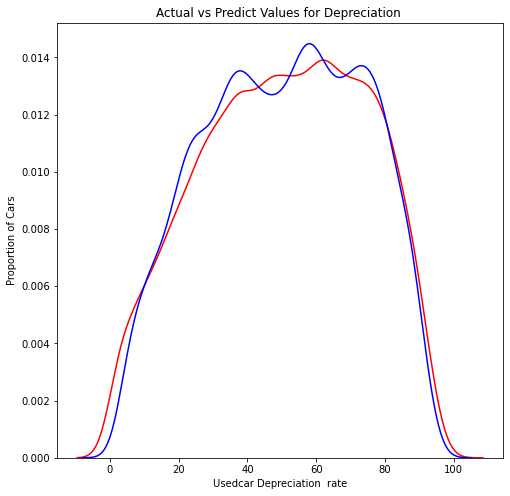

In [42]:
plt.figure(figsize=(8, 8))

ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(randomforest_predict, hist=False, color="b", label="Predict Value" , ax=ax1)

plt.title('Actual vs Predict Values for Depreciation ')
plt.xlabel('Usedcar Depreciation  rate')
plt.ylabel('Proportion of Cars')

plt.show()
plt.close()

In [52]:
joblib.dump(randforest, 'randforest+grid.pkl')

['randforest+grid.pkl']

# XGBoost + GridSearchCV

In [79]:
X = df[['use','nation','car_brand','car_name','mileage','year','car_type','fuel','trans','loss','flood','usage','change','insurance']] 
Y = df[['depreciation']]

In [80]:
encoded_X = pd.get_dummies(data = X, columns = ['nation','car_brand','car_name','car_type','fuel','trans','loss','flood','usage','insurance'])

In [81]:
scaled_X= s_scale.transform(encoded_X)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X,Y, random_state = 5, test_size = 0.25)

In [78]:
xgb_reg = xgboost.XGBRegressor()

grid_cv2 = GridSearchCV(xgb_reg, param_grid=params, cv=3, n_jobs=-1)
grid_cv2.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
print(f"Best Param: {grid_cv2.best_params_}")
print('최고 예측 정확도: {:.4f}'.format(grid_cv2.best_score_))
n_estimators = grid_cv2.best_params_['n_estimators']

In [93]:
xgb_reg = xgboost.XGBRegressor(learning_rate = 0.5,
                               n_estimators = 200)


In [94]:
xgb_reg.fit(X_train, np.ravel(y_train))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [95]:
# 모델명 변경해주기

xgb_reg_predict = xgb_reg.predict(X_test)

In [96]:
# 모델명, acc.append 부분 model 이름 변경해주기

print(f'train acc : {xgb_reg.score(X_train, y_train)}')
print(f'test acc : {xgb_reg.score(X_test, y_test)}')
print(f'MAE : {mean_absolute_error(y_test, xgb_reg_predict)}')
print(f'MSE : {mean_squared_error(y_test, xgb_reg_predict)}')
print(f'r2_score : {r2_score(y_test,xgb_reg_predict)}')

train acc : 0.9447199639466654
test acc : 0.9221233694108679
MAE : 4.600299318322649
MSE : 43.25558466137652
r2_score : 0.9221233694108679


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


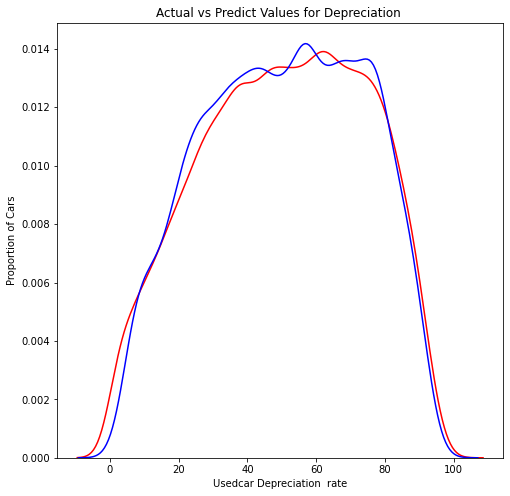

In [97]:
plt.figure(figsize=(8, 8))

ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(xgb_reg_predict, hist=False, color="b", label="Predict Values" , ax=ax1)

plt.title('Actual vs Predict Values for Depreciation ')
plt.xlabel('Usedcar Depreciation  rate')
plt.ylabel('Proportion of Cars')

plt.show()
plt.close()

In [53]:
joblib.dump(xgb_reg, 'xgb_reg+grid.pkl')

['xgb_reg+grid.pkl']